# Suitability Analysis For The New Venue Location

## Dependencies
This notebook uses the following dependencies:

* pandas
* numpy
* scikit-learn
* seaborn
* matplotlib
* h3
* catboost
* tqdm
* missingno

If those aren't already installed, run the following command:

<code> pip install pandas numpy scikit-learn seaborn matplotlib h3 catboost missingno </code>

This notebook was originally tested with the following package versions, but likely works with a broad range of versions:

* pandas==1.3.3
* numpy==1.21.2
* scikit-learn==0.24.2
* scipy==1.7.1
* seaborn==0.11.2
* matplotlib==3.4.3
* h3==3.7.3
* catboost==0.26.1
* tqdm==4.62.3
* missingno==0.5.0

## Imports

In [19]:
from statistics import mode
from uuid import uuid4

import h3
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import requests
import seaborn as sns

%matplotlib inline
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from unfolded.map_sdk import UnfoldedMap

## Data Loading

In [20]:
def load_data(url, path):
    response = requests.get(url, stream=True)
    total_size_in_bytes = int(response.headers.get("content-length", 0))
    block_size = 1024  # 1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)
    with open(path, "wb") as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)

    progress_bar.close()

In [21]:
foot_traffic_df_url = (
    "https://actionengine-public.s3.us-east-2.amazonaws.com/common_df.csv"
)
cities_df_url = "https://actionengine-public.s3.us-east-2.amazonaws.com/cities.csv"
foot_traffic_df_path = "foot_traffic_df.csv"
cities_df_path = "cities.csv"
load_data(foot_traffic_df_url, foot_traffic_df_path)
load_data(cities_df_url, cities_df_path)
foot_traffic_df = pd.read_csv(foot_traffic_df_path)
cities = pd.read_csv(cities_df_path)
foot_traffic_data = foot_traffic_df.merge(
    cities, how="left", on=["Neighbourhood Latitude", "Neighbourhood Longitude"]
)

foot_traffic_data.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.04M/4.04M [00:10<00:00, 392kiB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 314k/314k [00:00<00:00, 567kiB/s]


,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Address,Venue Latitude,Venue Longitude,Venue Category,County,raw_stop_counts,raw_device_counts,region,Total Population (Estimate),Total Population (MarginOfError),Median Household Income(Estimate),Median Household Income(MarginOfError),Unnamed: 0,block,District
0,40.824867,-73.818618,Travesias,3834 East Tremont Ave,40.82445883240027,-73.820451,Latin American Restaurant,Bronx,4184.0,1282.0,NY,1314.0,260.0,55700.0,8417.0,3804,360050158001,Bronx
1,40.824867,-73.818618,Burger Bar Ny,3841 E Tremont Ave,40.824315000000006,-73.819894,Burger Joint,Bronx,4184.0,1282.0,NY,1314.0,260.0,55700.0,8417.0,3804,360050158001,Bronx
2,40.824867,-73.818618,Uncle Al's Soul Food Kitchen,3841 E Tremont Ave,40.8243293762207,-73.819962,Southern / Soul Food Restaurant,Bronx,4184.0,1282.0,NY,1314.0,260.0,55700.0,8417.0,3804,360050158001,Bronx
3,40.824867,-73.818618,barrio bx,3764 E Tremont Ave,40.825764,-73.821561,Puerto Rican Restaurant,Bronx,4184.0,1282.0,NY,1314.0,260.0,55700.0,8417.0,3804,360050158001,Bronx
4,40.824867,-73.818618,15 Flavors NYC,3813 E Tremont Ave,40.8247318,-73.820084,Frozen Yogurt Shop,Bronx,4184.0,1282.0,NY,1314.0,260.0,55700.0,8417.0,3804,360050158001,Bronx


## Data Cleaning

Your selected dataframe has 18 columns.
There are 3 columns that have missing values.
                                        Missing Values  % of Total Values
Venue Address                                     3765               14.1
Median Household Income(MarginOfError)            2554                9.5
Median Household Income(Estimate)                 2285                8.5


<AxesSubplot:>

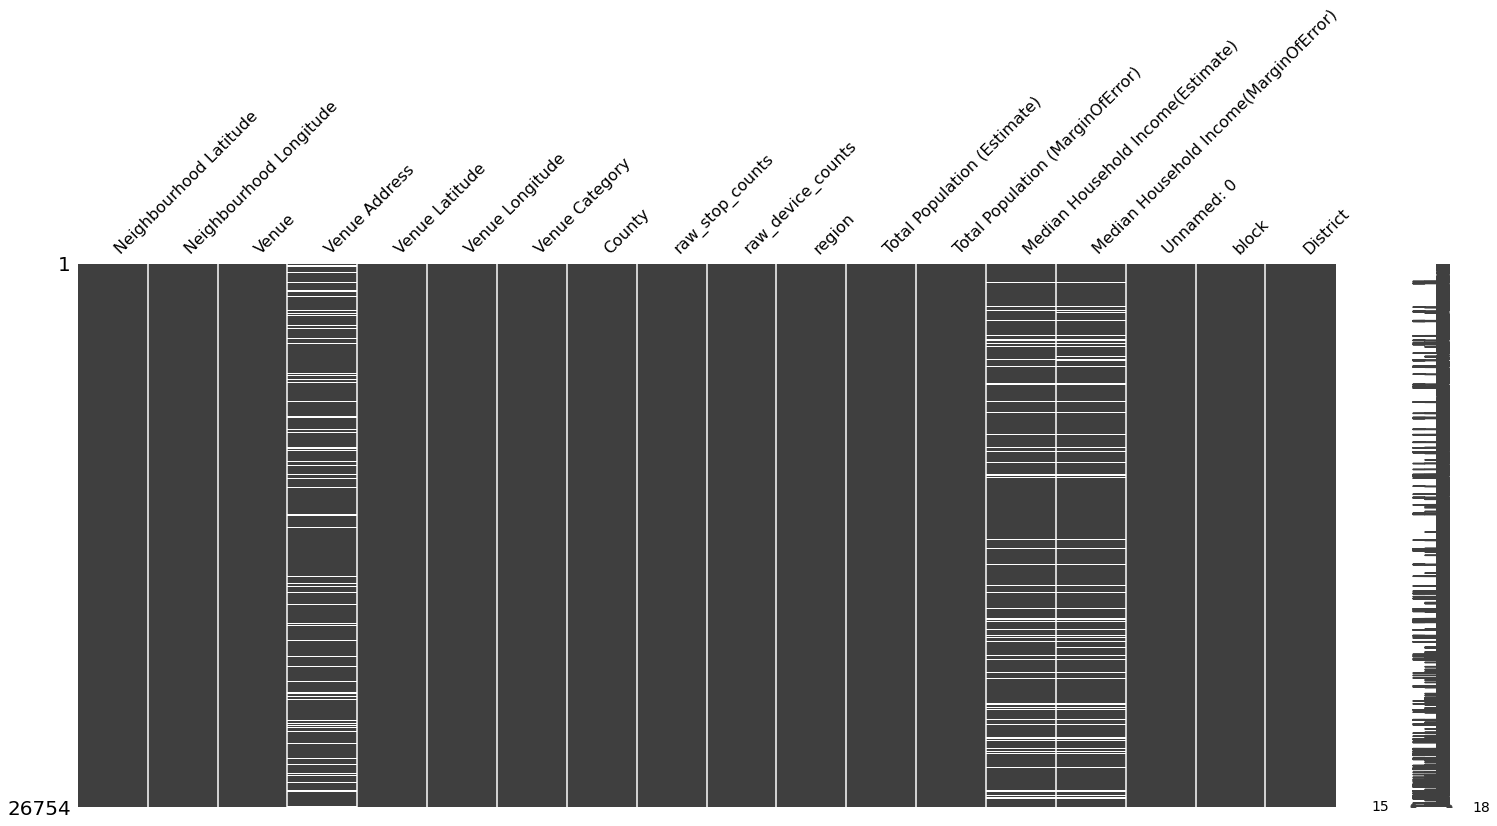

In [22]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )
    mis_val_table_ren_columns = (
        mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )
    print(
        "Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are "
        + str(mis_val_table_ren_columns.shape[0])
        + " columns that have missing values."
    )
    return mis_val_table_ren_columns


print(missing_values_table(foot_traffic_data))
msno.matrix(foot_traffic_data)

заполнение пропусков после дата сплита

Объединить ячейки логически

Get rid of lines with categories we are not interested in:

In [23]:
values = [
    "Gym / Fitness Center",
    "Convenience Store",
    "Market",
    "Music Venue",
    "College Lab",
    "Supermarket",
    "Record Shop",
    "Miscellaneous Shop",
    "Gas Station",
    "Residential Building (Apartment / Condo)",
    "Performing Arts Venue",
    "Office",
    "Souvlaki Shop",
    "Bowling Alley",
    "Playground",
    "Club House",
    "Bookstore",
    "Event Space",
    "Pool Hall",
    "Gift Shop",
    "Smoke Shop",
    "Hotel",
    "Flower Shop",
    "Art Gallery",
    "Cha Chaan Teng",
    "Warehouse Store",
    "Concert Hall",
    "Jazz Club",
    "Salon / Barbershop",
    "Supplement Shop",
    "Building",
    "Coworking Space",
    "Student Center",
    "Bike Shop",
    "Toy / Game Store",
    "Flea Market",
    "Shopping Mall",
    "Pet Store",
    "Amphitheater",
    "Chaat Place",
    "Clothing Store",
    "Furniture / Home Store",
    "Organic Grocery",
    "Motorcycle Shop",
    "Indoor Play Area",
    "Yoga Studio",
    "Used Bookstore",
    "Indie Movie Theater",
    "Pop-Up Shop",
    "Factory",
    "Boat or Ferry",
    "Dosa Place",
    "Animal Shelter",
    "Tanning Salon",
    "Vape Store",
    "Event Service",
    "Non-Profit",
    "Wine Shop",
    "Casino",
    "Beach",
    "Hobby Shop",
    "Pool",
    "Dog Run",
    "Bus Line",
    "Fire Station",
    "EV Charging Station",
    "Gay Bar",
    "Farm",
    "Resort",
    "Doctor's Office",
    "Internet Cafe",
    "Laundry Service",
    "-73.8572949306213",
]


def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]


foot_traffic_data = filter_rows_by_values(foot_traffic_data, "Venue Category", values)

## Data Visualization

Here we'll create a map that clusters by districts with the largest population. Note that since the clustering happens within Unfolded Studio, the clusters change as you zoom in, allowing you to explore your data at various resolutions.

In [24]:
neighbourhoods = foot_traffic_df.drop_duplicates(
    subset=["Neighbourhood Latitude", "Neighbourhood Longitude"]
)

population_neighbourhoods = UnfoldedMap()

# Create a persistent dataset ID that we can reference in both add_dataset and add_layer
dataset_id = uuid4()

population_neighbourhoods.add_dataset(
    {
        "uuid": dataset_id,
        "label": "population_neighbourhoods_NY",
        "data": neighbourhoods,
    },
    auto_create_layers=False,
)

population_neighbourhoods.add_layer(
    {
        "id": "population_neighbourhoods",
        "type": "cluster",
        "config": {
            "label": "population in NY",
            "data_id": dataset_id,
            "columns": {
                "lat": "Neighbourhood Latitude",
                "lng": "Neighbourhood Longitude",
            },
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {"name": "Total Population (Estimate)", "type": "real"},
            "vis_config": {
                "colorRange": {
                    "colors": [
                        "#355C7D",
                        "#63617F",
                        "#916681",
                        "#D88185",
                        "#E8998D",
                        "#F8B195",
                    ]
                }
            },
        },
    }
)
population_neighbourhoods.set_view_state(
    {"longitude": -73.769652, "latitude": 40.710574, "zoom": 9}
)

population_neighbourhoods

UnfoldedMap()

This map that clusters by districts with the largest incomes.

In [25]:
incomes_neighbourhoods = UnfoldedMap()

# Create a persistent dataset ID that we can reference in both add_dataset and add_layer
dataset_id = uuid4()

incomes_neighbourhoods.add_dataset(
    {"uuid": dataset_id, "label": "venues_NY", "data": neighbourhoods},
    auto_create_layers=False,
)

incomes_neighbourhoods.add_layer(
    {
        "id": "incomes_neighbourhoods",
        "type": "hexagon",
        "config": {
            "label": "incomes in NY by neighbourhoods",
            "data_id": dataset_id,
            "columns": {
                "lat": "Neighbourhood Latitude",
                "lng": "Neighbourhood Longitude",
            },
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {
                "name": "Median Household Income(Estimate)",
                "type": "real",
            },
            "vis_config": {
                "colorRange": {
                    "colors": [
                        "#006837",
                        "#31A354",
                        "#78C679",
                        "#ADDD8E",
                        "#D9F0A3",
                        "#FFFFCC",
                    ]
                }
            },
        },
    }
)

incomes_neighbourhoods.set_view_state(
    {"longitude": -73.769652, "latitude": 40.710574, "zoom": 9}
)

incomes_neighbourhoods

UnfoldedMap()

## Feature Engineering

Group data by district, then count the number of venues of each category for each district, and based on this, make a clustering of districts.

In [26]:
districts_by_venue_cat = (
    foot_traffic_data.groupby(["District", "Venue Category"])["Venue Category"]
    .aggregate("count")
    .unstack()
)
districts_by_venue_cat = districts_by_venue_cat.fillna(0)

districts_by_venue_cat_copy = (
    districts_by_venue_cat.reset_index()
    .rename_axis(None, axis=1)
    .drop(["District"], axis=1)
)

### Feature Scaling

In [27]:
districts_by_venue_cat_copy["sum"] = districts_by_venue_cat_copy.sum(axis=1)

districts_by_venue_cat_copy = districts_by_venue_cat_copy.div(
    districts_by_venue_cat_copy["sum"], axis=0
)

districts_by_venue_cat_copy.drop(["sum"], axis=1, inplace=True)

Using the elbow method, we determine how many clusters we can divide the data

Text(0.5, 1.0, 'Elbow Method For Optimal k')

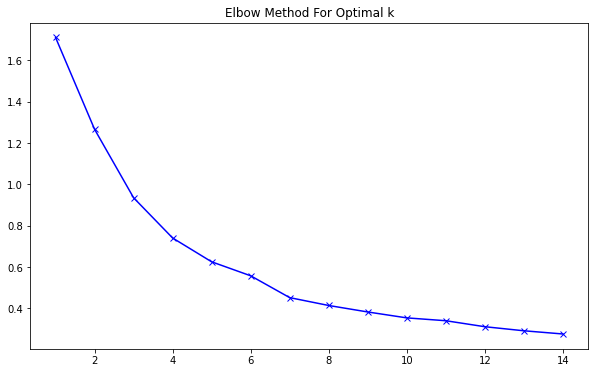

In [28]:
# Elbow method for clustering
sum_of_squared_distances = []

K = range(1, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(districts_by_venue_cat_copy)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, "bx-")
plt.title("Elbow Method For Optimal k")

According to the graph above, the optimal value is 7

In [29]:
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(districts_by_venue_cat_copy)

districts_by_venue_cat["Label"] = kmeans.labels_

Insert the resulting cluster label into the main dataset

In [30]:
districts_by_venue_cat = districts_by_venue_cat.reset_index()

foot_traffic_data = foot_traffic_data.merge(
    districts_by_venue_cat[["District", "Label"]], how="left", on="District"
)

We will leave only those columns that are needed to build the model.

In [31]:
final_df = foot_traffic_data[
    [
        "Neighbourhood Latitude",
        "Neighbourhood Longitude",
        "Venue Category",
        "Venue Latitude",
        "Venue Longitude",
        "County",
        "District",
        "Label",
        "Total Population (Estimate)",
        "Total Population (MarginOfError)",
        "Median Household Income(Estimate)",
        "Median Household Income(MarginOfError)",
        "raw_device_counts",
    ]
]

final_df

,Neighbourhood Latitude,Neighbourhood Longitude,Venue Category,Venue Latitude,Venue Longitude,County,District,Label,Total Population (Estimate),Total Population (MarginOfError),Median Household Income(Estimate),Median Household Income(MarginOfError),raw_device_counts
0,40.824867,-73.818618,Latin American Restaurant,40.82445883240027,-73.820451,Bronx,Bronx,4,1314.0,260.0,55700.0,8417.0,1282.0
1,40.824867,-73.818618,Burger Joint,40.824315000000006,-73.819894,Bronx,Bronx,4,1314.0,260.0,55700.0,8417.0,1282.0
2,40.824867,-73.818618,Southern / Soul Food Restaurant,40.8243293762207,-73.819962,Bronx,Bronx,4,1314.0,260.0,55700.0,8417.0,1282.0
3,40.824867,-73.818618,Puerto Rican Restaurant,40.825764,-73.821561,Bronx,Bronx,4,1314.0,260.0,55700.0,8417.0,1282.0
4,40.824867,-73.818618,Frozen Yogurt Shop,40.8247318,-73.820084,Bronx,Bronx,4,1314.0,260.0,55700.0,8417.0,1282.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26578,40.708992,-73.948808,Thai Restaurant,40.71404479091751,-73.950037,Kings,Brooklyn,4,1696.0,336.0,40870.0,25696.0,333.0
26579,40.900554,-73.850484,Caribbean Restaurant,40.8985014181645,-73.855340,Bronx,Bronx,4,1093.0,334.0,53750.0,10280.0,1700.0
26580,40.900554,-73.850484,Pizza Place,40.89844256649264,-73.854851,Bronx,Bronx,4,1093.0,334.0,53750.0,10280.0,1700.0
26581,40.900554,-73.850484,Bagel Shop,40.898392729492464,-73.854321,Bronx,Bronx,4,1093.0,334.0,53750.0,10280.0,1700.0


Visualize the principle of clustering 

In [32]:
clustering_of_district = UnfoldedMap()

# Create a persistent dataset ID that we can reference in both add_dataset and add_layer
dataset_id = uuid4()

clustering_of_district.add_dataset(
    {"uuid": dataset_id, "label": "district clustreing", "data": final_df},
    auto_create_layers=False,
)

clustering_of_district.add_layer(
    {
        "id": "incomes_neighbourhoods",
        "type": "point",
        "config": {
            "label": "incomes in NY by neighbourhoods",
            "data_id": dataset_id,
            "columns": {
                "lat": "Neighbourhood Latitude",
                "lng": "Neighbourhood Longitude",
            },
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {"name": "Label", "type": "real",},
            "vis_config": {
                "colorRange": {
                    "colors": [
                        "#B35806",
                        "#F1A340",
                        "#FEE0B6",
                        "#D8DAEB",
                        "#998EC3",
                        "#542788",
                    ]
                }
            },
        },
    }
)

clustering_of_district.set_view_state(
    {"longitude": -73.769652, "latitude": 40.710574, "zoom": 9}
)

clustering_of_district

UnfoldedMap()

## Data Preprocessing

In [33]:
final_df["Venue Latitude"] = pd.to_numeric(final_df["Venue Latitude"])
X = final_df.drop(["raw_device_counts"], axis=1)
y = final_df[["raw_device_counts"]]

/tmp/ipykernel_172861/3514484295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["Venue Latitude"] = pd.to_numeric(final_df["Venue Latitude"])


## Data Splitting

We split the data into training, validation and test sets

In [34]:
# dividing training data into test, validation and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1
)

# define categorical features
cat_features = [i for i in X.columns if X.dtypes[i] == "object"]

As we mentioned before, two important columns contain empty values, for this reason fill them with median value.

In [35]:
empty_values = [
    "Median Household Income(Estimate)",
    "Median Household Income(MarginOfError)",
]


def fill_empty_values(df, columns):
    for column in columns:
        df[column].fillna(
            df[column].median(axis=0), axis=0, inplace=True,
        )


fill_empty_values(X_train, empty_values)
fill_empty_values(X_val, empty_values)
fill_empty_values(X_test, empty_values)

/home/ksenia-evin/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/home/ksenia-evin/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


## Foot Traffic Prediction Model

### Building

We use here CatBoost (new open-source machine learning algorithm, developed in 2017 by Yandex company), because it offers a way of handling categorical data. Also builds upon the theory of decision trees and gradient boosting and thus through greedy search create a strong competitive predictive model.

In [53]:
model = CatBoostRegressor(
    iterations=1000, depth=6, learning_rate=0.1, loss_function="RMSE"
)

model.fit(
    X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), plot=True
)

pred = model.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4449.7484536	test: 5112.2198293	best: 5112.2198293 (0)	total: 5.77ms	remaining: 5.77s
1:	learn: 4154.9937768	test: 4785.5251243	best: 4785.5251243 (1)	total: 14.3ms	remaining: 7.14s
2:	learn: 3895.5760412	test: 4498.6794784	best: 4498.6794784 (2)	total: 20.7ms	remaining: 6.87s
3:	learn: 3667.3082093	test: 4246.8832130	best: 4246.8832130 (3)	total: 28.1ms	remaining: 7.01s
4:	learn: 3459.6140413	test: 4018.7547163	best: 4018.7547163 (4)	total: 36.6ms	remaining: 7.29s
5:	learn: 3283.7063530	test: 3825.2781084	best: 3825.2781084 (5)	total: 44.6ms	remaining: 7.39s
6:	learn: 3125.4187297	test: 3653.1545692	best: 3653.1545692 (6)	total: 51.6ms	remaining: 7.32s
7:	learn: 2985.8292621	test: 3499.6516307	best: 3499.6516307 (7)	total: 57.8ms	remaining: 7.17s
8:	learn: 2869.2544958	test: 3378.9355081	best: 3378.9355081 (8)	total: 64.7ms	remaining: 7.13s
9:	learn: 2756.7972906	test: 3256.6068954	best: 3256.6068954 (9)	total: 71.5ms	remaining: 7.08s
10:	learn: 2658.9553652	test: 3146.48773

### H3 grid

Divide all site data with a hexagonal grid

In [37]:
final_df["h3_idx"] = final_df.apply(
    lambda row: h3.geo_to_h3(row["Venue Latitude"], row["Venue Longitude"], 10), axis=1
)

/tmp/ipykernel_172861/695775964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["h3_idx"] = final_df.apply(


In [38]:
grouped_by_h3 = final_df.groupby(["h3_idx"]).agg(
    {
        "Neighbourhood Latitude": lambda x: list(x),
        "Neighbourhood Longitude": lambda x: list(x),
        "County": lambda x: list(x),
        "District": lambda x: list(x),
        "Label": lambda x: list(x),
        "Total Population (Estimate)": "mean",
        "Total Population (MarginOfError)": "mean",
        "Median Household Income(Estimate)": "mean",
        "Median Household Income(MarginOfError)": "mean",
    }
)

In [39]:
X_test_H3 = grouped_by_h3.reset_index()

X_test_H3["lat_lon"] = X_test_H3.apply(lambda row: h3.h3_to_geo(row["h3_idx"]), axis=1)

X_test_H3["lat_lon"] = X_test_H3["lat_lon"].map(
    lambda x: str(x).lstrip("(").rstrip(")")
)
X_test_H3[["Venue Latitude", "Venue Longitude"]] = X_test_H3.lat_lon.str.split(
    ",", expand=True
)

X_test_H3["Neighbourhood Latitude"] = X_test_H3["Neighbourhood Latitude"].apply(
    lambda row: mode(row)
)
X_test_H3["Neighbourhood Longitude"] = X_test_H3["Neighbourhood Longitude"].apply(
    lambda row: mode(row)
)
X_test_H3["County"] = X_test_H3["County"].apply(lambda row: mode(row))
X_test_H3["District"] = X_test_H3["District"].apply(lambda row: mode(row))
X_test_H3["Label"] = X_test_H3["Label"].apply(lambda row: mode(row))

X_test_H3 = X_test_H3.drop(["lat_lon"], axis=1)
X_test_H3["Venue Category"] = "Pizza Place"

X_test_H3 = X_test_H3[
    [
        "h3_idx",
        "Neighbourhood Latitude",
        "Neighbourhood Longitude",
        "Venue Category",
        "Venue Latitude",
        "Venue Longitude",
        "County",
        "District",
        "Label",
        "Total Population (Estimate)",
        "Total Population (MarginOfError)",
        "Median Household Income(Estimate)",
        "Median Household Income(MarginOfError)",
    ]
]

### Prediction

In [40]:
predicted_data = X_test_H3.copy()

X_test_H3 = X_test_H3.drop(["h3_idx"], axis=1)

predicted_devices_counts_by_h3 = model.predict(X_test_H3)

predicted_data["raw_device_count"] = predicted_devices_counts_by_h3

This map shows the subdivision of a city using a H3 grid.

In [41]:
raw_devices_data_by_h3 = UnfoldedMap()

# Create a persistent dataset ID that we can reference in both add_dataset and add_layer
dataset_id = uuid4()

raw_devices_data_by_h3.add_dataset(
    {"uuid": dataset_id, "label": "venues_NY", "data": predicted_data},
    auto_create_layers=False,
)

raw_devices_data_by_h3.add_layer(
    {
        "id": "raw_devices_data_by_h3",
        "type": "hexagonId",
        "config": {
            "data_id": dataset_id,
            "label": "h3_idx",
            "columns": {"hex_id": "h3_idx"},
            "color_field": {"name": "raw_device_count", "type": "real"},
            "is_visible": True,
            "vis_config": {
                "opacity": 0.8,
                "color_range": {
                    "name": "ColorBrewer Reds-6",
                    "type": "singlehue",
                    "category": "ColorBrewer",
                    "colors": [
                        "#fee5d9",
                        "#fcbba1",
                        "#fc9272",
                        "#fb6a4a",
                        "#de2d26",
                        "#a50f15",
                    ],
                },
            },
            "hidden": False,
        },
    }
)

raw_devices_data_by_h3.set_view_state(
    {"longitude": -73.769652, "latitude": 40.710574, "zoom": 9}
)

raw_devices_data_by_h3

UnfoldedMap()

### Visualize results

This map shows predicted count of devices by districts of NYC

In [42]:
venues_NY = UnfoldedMap()

# Create a persistent dataset ID that we can reference in both add_dataset and add_layer
dataset_id = uuid4()

venues_NY.add_dataset(
    {"uuid": dataset_id, "label": "venues_NY", "data": predicted_data},
    auto_create_layers=False,
)

venues_NY.add_layer(
    {
        "id": "foot_traffic_data_by_venues",
        "type": "point",
        "config": {
            "data_id": dataset_id,
            "label": "Predicted Foot Traffic By raw_device_count",
            "columns": {"lat": "Venue Latitude", "lng": "Venue Longitude"},
            "color_field": {"name": "raw_device_count", "type": "real"},
            "is_visible": True,
            "color_scale": "quantile",
            "vis_config": {
                "opacity": 0.08,
                "colorRange": {
                    "colors": [
                        "#2B1E3E",
                        "#343D5E",
                        "#4F777E",
                        "#709E87",
                        "#99BE95",
                        "#D6DEBF",
                    ],
                },
            },
        },
    }
)

venues_NY.set_view_state({"longitude": -73.769652, "latitude": 40.710574, "zoom": 9})

venues_NY

UnfoldedMap()

Visualize the results with a heatmap, we can see the areas with the highest foot traffic

In [43]:
venues_NY_heatmap = UnfoldedMap()

# Create a persistent dataset ID that we can reference in both add_dataset and add_layer
dataset_id = uuid4()

venues_NY_heatmap.add_dataset(
    {"uuid": dataset_id, "label": "venues_NY", "data": predicted_data},
    auto_create_layers=False,
)

venues_NY_heatmap.add_layer(
    {
        "id": "foot_traffic_data_by_venues",
        "type": "heatmap",
        "config": {
            "dataId": dataset_id,
            "label": "Predicted Foot Traffic By raw_device_count",
            "columns": {"lat": "Venue Latitude", "lng": "Venue Longitude"},
            "is_visible": True,
            "vis_config": {
                "opacity": 0.8,
                "colorRange": {
                    "name": "Global Warming",
                    "type": "sequential",
                    "category": "Uber",
                    "colors": [
                        "#5A1846",
                        "#900C3F",
                        "#C70039",
                        "#E3611C",
                        "#F1920E",
                        "#FFC300",
                    ],
                },
                "radius": 20,
                "intensity": 0.5,
                "threshold": 0.189,
            },
            "hidden": False,
        },
        "visual_channels": {
            "weight_field": {"name": "raw_device_count", "type": "real"},
            "weight_scale": "",
        },
    }
)

venues_NY_heatmap.set_view_state(
    {"longitude": -73.769652, "latitude": 40.710574, "zoom": 9}
)

venues_NY_heatmap

UnfoldedMap()